In [1]:
from collections import defaultdict
import os
import pathlib
import pickle

from astropy.stats import median_absolute_deviation as MAD
from astropy.utils.misc import isiterable
import astropy.table as at
from astropy.time import Time
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import binned_statistic, binned_statistic_2d
from tqdm.notebook import tqdm
from scipy.spatial import cKDTree

from gala.mpl_style import turbo

import arviz as az
import pymc3 as pm
import theano.tensor as tt
from scipy.stats import cauchy, norm
from scipy.special import logsumexp
import exoplanet as xo

In [2]:
def get_bin_mask(allstar, **kwargs):
    bin_mask = np.ones(len(allstar), dtype=bool)
    
    for k, lim in kwargs.items():
        bin_mask &= (allstar[k] > lim[0]) & (allstar[k] < lim[1]) 
        
    return bin_mask


def equal_N_bins(x, N_per_bin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, N_per_bin + 1),
                     np.arange(npt),
                     np.sort(x))

In [3]:
# DR17 alpha
allstar = at.Table.read('/mnt/home/apricewhelan/data/APOGEE_DR17/allStar-dr17-l33alpha.fits', 
                        hdu=1)
allstar = at.unique(allstar, keys='APOGEE_ID')

allvisit = at.Table.read('/mnt/home/apricewhelan/data/APOGEE_DR17/allVisitLite-dr17-l33alpha.fits',
                         hdu=1)

In [4]:
# BITMASK shiz
allstar = allstar[((allstar['ASPCAPFLAG'] & (2**23)) == 0) &
                  (allstar['M_H'] > -2.5)]

starflag_bits = np.array([0, 3, 9, 16, 17])
starflag_mask = (allvisit['STARFLAG'] % np.sum(2**starflag_bits)) == 0

# RV_FLAG and SB2
visit_rv_mask = ((allvisit['N_COMPONENTS'] == 1) & 
                 (allvisit['RV_FLAG'] == 0) &
                 (allvisit['SNR'] > 4) &
                 (np.isfinite(allvisit['VHELIO'])))

allvisit = allvisit[starflag_mask & visit_rv_mask]

In [5]:
# with multiple visits:
allstar = allstar[allstar['NVISITS'] >= 3]

## Model:

$$
\begin{align}
\sigma_v^2 &= a^2 + b^2 \, \left( \frac{\rm SNR}{{\rm SNR}_0} \right)^{-2}\\
Z &= 10^{[{\rm M}/{\rm H}]}\\
a &= a_{0} + a_{Z, 1} \, (Z - Z_0)\\
b &= b_{0} + b_{Z, 1} \, (Z - Z_0)
\end{align}
$$

In [7]:
with pm.Model() as model:
    snr0 = pm.Data('snr0', 40.)
    Z0 = pm.Data('Z0', 1.)
    
    vs = pm.Data('vs', np.zeros(1))
    snrs = pm.Data('snrs', np.zeros(1))
    teffs = pm.Data('teffs', np.zeros(1))
    m_hs = pm.Data('m_hs', np.zeros(1))
    loggs = pm.Data('loggs', np.zeros(1))
    
    # cluster sizes
    K = 3
    ws = pm.Dirichlet("w", a=np.ones(K), shape=K)
    
    # noise
    Z = 10 ** m_hs
    a_z0 = pm.Uniform('a_z0', 0, 0.2)
    a_z1 = pm.Uniform('a_z1', -0.1, 0)
    a = a_z0 + a_z1 * (Z-Z0)
    
    b_0 = pm.Uniform('b_0', 0, 0.25)
    b_z1 = pm.Uniform('b_z1', -0.1, 0.1)
    b = b_0 + b_z1 * (Z-Z0)
    
    err1 = np.sqrt(a**2 + b**2 / (snrs / snr0)**2)
    norm1 = pm.Normal.dist(0, err1)
    
    # binaries
    lnbs1 = pm.Uniform('lnbs1', -0.7, 4)
    binary_std1 = tt.exp(lnbs1)
    err2 = np.sqrt(err1**2 + binary_std1**2)
    norm2 = pm.Normal.dist(0, err2)
    
    # excess variance
    lnbs2 = pm.Uniform('lnbs2', 1.6, 5.5)
    binary_std2 = tt.exp(lnbs2)
    err3 = np.sqrt(err2**2 + binary_std2**2)
    norm3 = pm.Normal.dist(0, err3)

    # likelihood for each observed value
    like = pm.Mixture('like', 
                      w=ws, 
                      comp_dists=[norm1, norm2, norm3],
                      observed=vs)

### Metric and grid setup

Overlapping bins, for a given star, take the box center closest to the star's position in logg, teff

In [8]:
teff_step = 300
logg_step = 0.4

teff_half_size = teff_step * 3 / 2
logg_half_size = logg_step * 3 / 2

teff_ctrs = np.arange(3000, 8000+1e-3, teff_step)
logg_ctrs = np.arange(-logg_step, 6+1e-3, logg_step)

teff_grid, logg_grid = np.meshgrid(teff_ctrs, logg_ctrs)

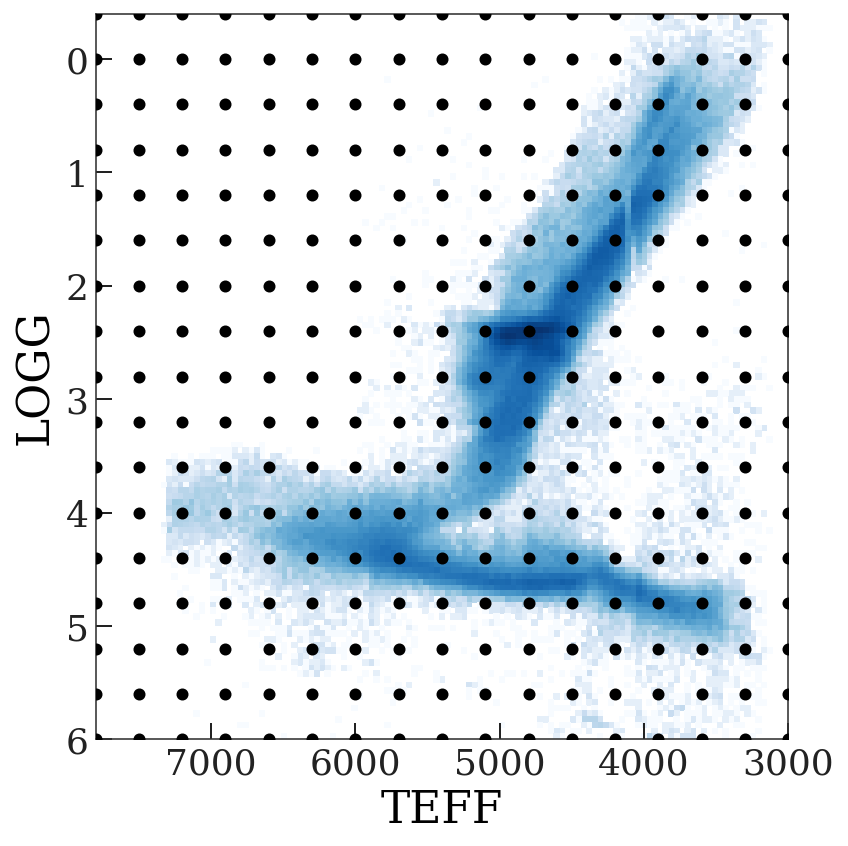

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.hist2d(allstar['TEFF'], allstar['LOGG'], 
          bins=(np.linspace(teff_ctrs.min(), teff_ctrs.max(), 128),
                np.linspace(logg_ctrs.min(), logg_ctrs.max(), 128)),
          norm=mpl.colors.LogNorm(),
          cmap='Blues');

ax.scatter(teff_grid.ravel(), 
           logg_grid.ravel(), 
           zorder=100)

ax.set_xlabel('TEFF')

ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

In [10]:
def get_visits(**kwargs):
    bin_mask = get_bin_mask(
        allstar, **kwargs) 
    
    stars = allstar[bin_mask]
    visits = allvisit[np.isin(allvisit['APOGEE_ID'], stars['APOGEE_ID'])]
    
    if len(stars) < 1 or len(visits) < 1:
        return None, None
    
    visits = at.join(visits, stars['APOGEE_ID', 'VHELIO_AVG', 'TEFF', 'LOGG', 'M_H'], 
                     keys='APOGEE_ID', join_type='left')
    visits['DVHELIO'] = visits['VHELIO'] - visits['VHELIO_AVG']
    
    return stars, visits


def visits_to_data(visits):
    data = {
        'vs': np.array(visits['DVHELIO']),
        'teffs' : np.array(visits['TEFF']),
        'snrs': np.array(visits['SNR']),
        'm_hs': np.array(visits['M_H']),
        'loggs': np.array(visits['LOGG'])
    }
    return data


def get_MAP_estimate(visits, model, init_pars=None, **kwargs):
    if init_pars is None:
        init_pars = {
            'a_z0': 0.05,
            'a_z1': -0.003,
            'b_0': 0.05,
            'b_z1': 0.,
            'lnbs1': 1.6,
            'lnbs2': 4.5,
            'w': np.ones(K)
        }

    data = visits_to_data(visits)

    with model:
        pm.set_data(data)
        map_estimate = pm.find_MAP(
            start=init_pars.copy(),
            **kwargs)
    
    return map_estimate

In [ ]:
pickle_file = pathlib.Path('../cache/logg_teff_grid_MAPs.pkl')
pickle_file.parent.mkdir(exist_ok=True)

In [ ]:
N_visit_min = 256
N_star_min = 64

if not pickle_file.exists():
    bin_means = []
    map_estimates = []
    for teff_val, logg_val in zip(teff_grid.ravel(), 
                                  logg_grid.ravel()):
        teff_lim = (teff_val - teff_half_size, teff_val + teff_half_size)
        logg_lim = (logg_val - logg_half_size, logg_val + logg_half_size)
        stars, visits = get_visits(
            TEFF=teff_lim,
            LOGG=logg_lim,
            M_H=(-2.5, 1))

        if stars is None or len(visits) < N_visit_min or len(stars) < N_star_min:
            continue

        print(f"TEFF: ({teff_lim[0]:.0f}, {teff_lim[1]:.0f}), " + 
              f"LOGG: ({logg_lim[0]:.1f}, {logg_lim[1]:.1f}), " + 
              f'N stars: {len(stars)},  N visits: {len(visits)}')

        # NOTE: this is but one choice in the multiverse of choices
        # i.e. we might want to mean over visits instead!
        bin_means.append([
            stars['TEFF'].mean(), 
            stars['LOGG'].mean()
        ])

        map_estimate = get_MAP_estimate(visits, model)
        map_estimates.append(map_estimate)

    bin_means = np.array(bin_means)
    
    with open(pickle_file, 'wb') as f:
        pickle.dump((bin_means, map_estimates), f)
        
with open(pickle_file, 'rb') as f:
    pickle.dump((bin_means, map_estimates), f)

TEFF: (2550, 3450), LOGG: (-1.0, 0.2), N stars: 314,  N visits: 669


logp = -619.38, ||grad|| = 0.0017811: 100%|██████████| 52/52 [00:00<00:00, 923.01it/s]  


TEFF: (2850, 3750), LOGG: (-1.0, 0.2), N stars: 906,  N visits: 3934


logp = -5,449.6, ||grad|| = 0.030392: 100%|██████████| 33/33 [00:00<00:00, 319.76it/s]  


TEFF: (3150, 4050), LOGG: (-1.0, 0.2), N stars: 1409,  N visits: 7543


logp = -10,969, ||grad|| = 2.4871: 100%|██████████| 48/48 [00:00<00:00, 184.41it/s]  


TEFF: (3450, 4350), LOGG: (-1.0, 0.2), N stars: 1143,  N visits: 7120


logp = -10,813, ||grad|| = 0.10361: 100%|██████████| 56/56 [00:00<00:00, 192.76it/s]  


TEFF: (3750, 4650), LOGG: (-1.0, 0.2), N stars: 552,  N visits: 3859


logp = -6,027.6, ||grad|| = 0.019008: 100%|██████████| 52/52 [00:00<00:00, 321.18it/s]  


TEFF: (2550, 3450), LOGG: (-0.6, 0.6), N stars: 702,  N visits: 1688


logp = -1,410.4, ||grad|| = 0.39651: 100%|██████████| 48/48 [00:00<00:00, 588.95it/s]  


TEFF: (2850, 3750), LOGG: (-0.6, 0.6), N stars: 3215,  N visits: 10434


logp = -11,045, ||grad|| = 2.2722: 100%|██████████| 57/57 [00:00<00:00, 139.03it/s]  


TEFF: (3150, 4050), LOGG: (-0.6, 0.6), N stars: 7501,  N visits: 37760


logp = -39,092, ||grad|| = 0.089944: 100%|██████████| 33/33 [00:00<00:00, 42.71it/s]  


TEFF: (3450, 4350), LOGG: (-0.6, 0.6), N stars: 7058,  N visits: 37283


logp = -39,614, ||grad|| = 56.806: 100%|██████████| 29/29 [00:00<00:00, 43.28it/s]  


TEFF: (3750, 4650), LOGG: (-0.6, 0.6), N stars: 4567,  N visits: 28584


logp = -29,918, ||grad|| = 0.89353: 100%|██████████| 44/44 [00:00<00:00, 55.14it/s]  


TEFF: (4050, 4950), LOGG: (-0.6, 0.6), N stars: 278,  N visits: 1270


logp = -1,934.7, ||grad|| = 0.10661: 100%|██████████| 59/59 [00:00<00:00, 675.67it/s]  


TEFF: (2550, 3450), LOGG: (-0.2, 1.0), N stars: 689,  N visits: 1701


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_teff_logg_bins = (
    np.linspace(teff_ctrs.min(), teff_ctrs.max(), 128),
    np.linspace(logg_ctrs.min(), logg_ctrs.max(), 128)
)

ax.hist2d(allstar['TEFF'], allstar['LOGG'], 
          bins=plot_teff_logg_bins,
          norm=mpl.colors.LogNorm(),
          cmap='Blues');

ax.scatter(bin_means[:, 0],
           bin_means[:, 1],
           zorder=100)

ax.set_xlabel('TEFF')

ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

Find the nearest bin:

In [58]:
X = np.stack((allstar['TEFF'], allstar['LOGG'])).T
metric = np.array([teff_step, logg_step])

In [62]:
kdtree = cKDTree(bin_means / metric)
dist, idx = kdtree.query(X / metric)

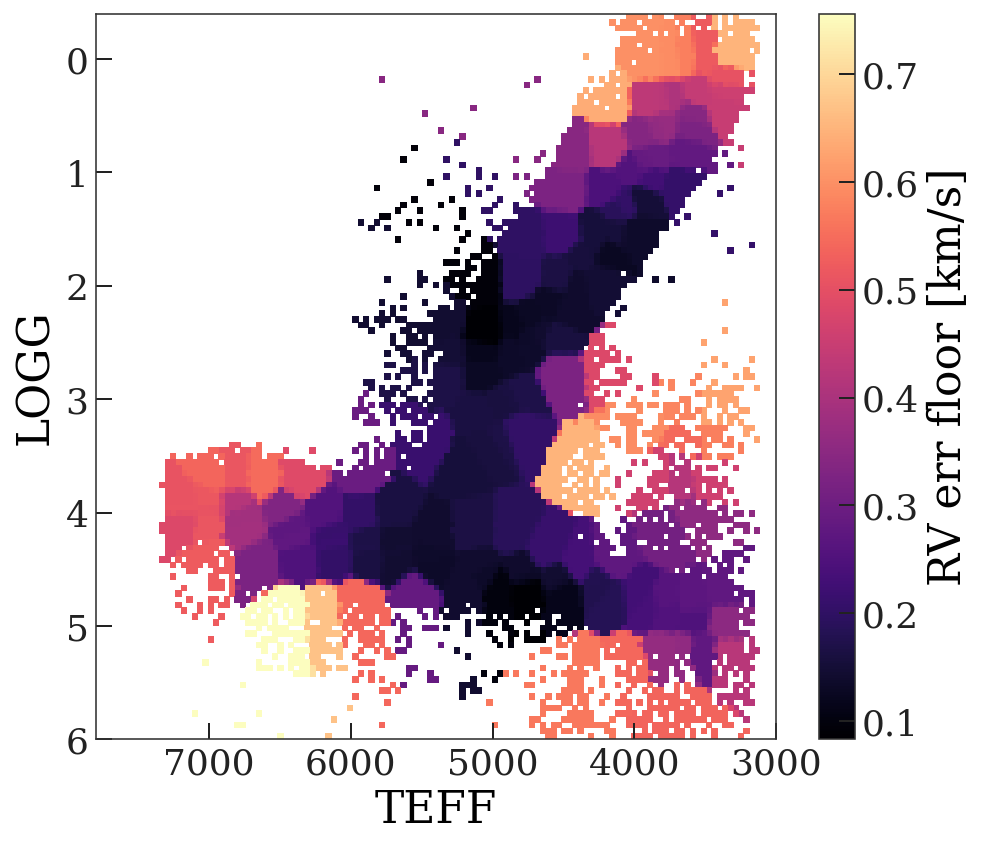

In [82]:
arr = np.full(len(idx), np.nan)
for i in np.unique(idx):
    if i >= len(map_estimates):
        continue
        
    # arr[idx == i] = sum(map_estimates[i]['w'][1:])
    arr[idx == i] = sum(map_estimates[i]['b'][1:])

stat = binned_statistic_2d(X[:, 0], X[:, 1], arr, 
                           bins=plot_teff_logg_bins)

fig, ax = plt.subplots(figsize=(7, 6))

cs = ax.pcolormesh(stat.x_edge, stat.y_edge, stat.statistic.T)

cb = fig.colorbar(cs)
cb.set_label('RV err floor [km/s]')

ax.set_xlabel('TEFF')
ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

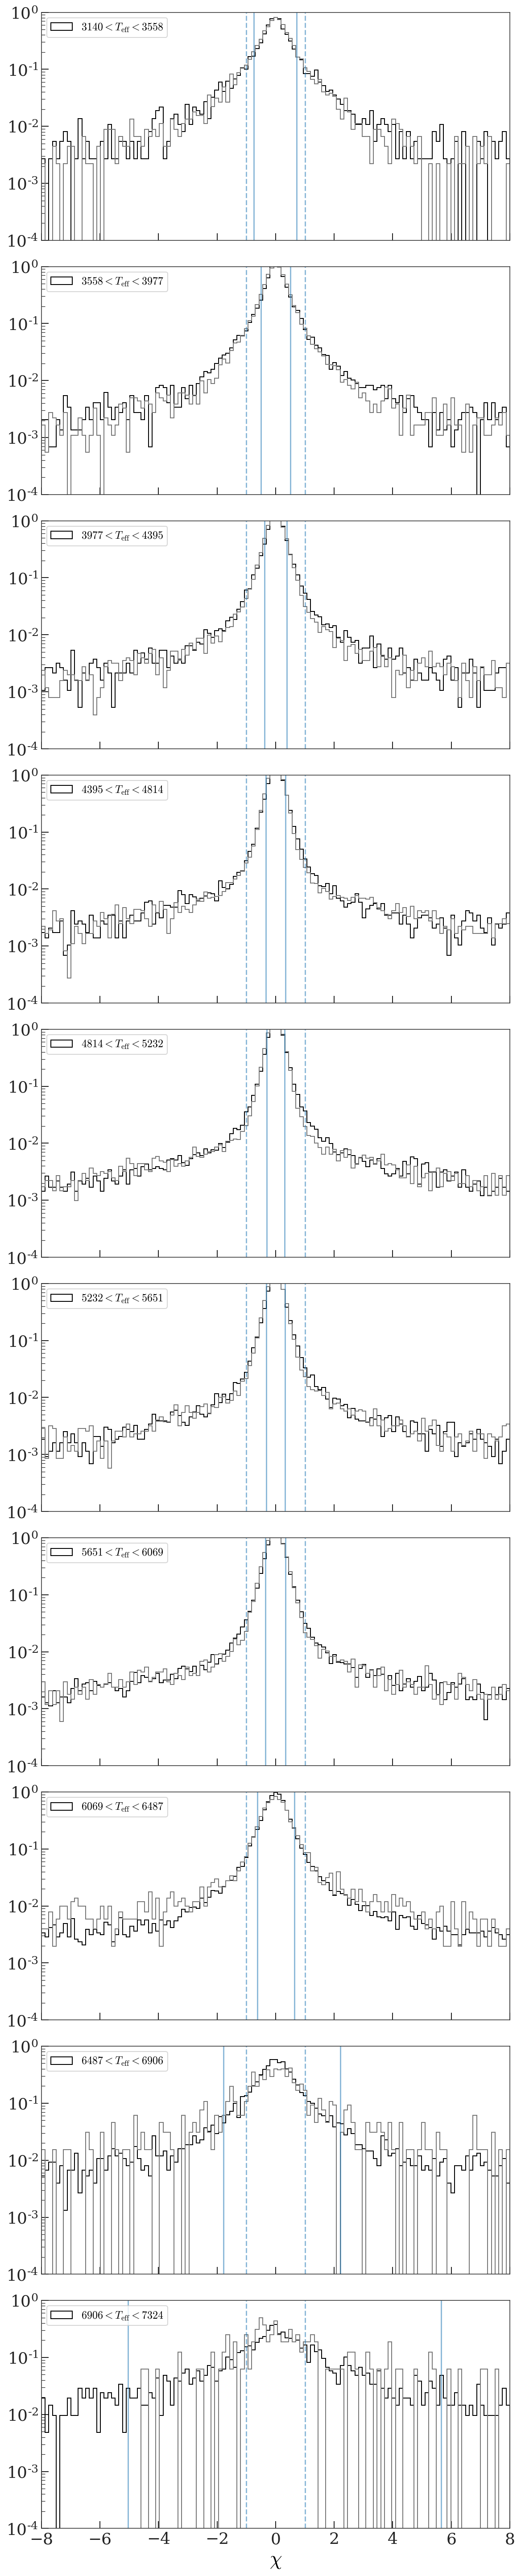

In [123]:
fig, axes = plt.subplots(Nbins, 1, figsize=(8, 4 * Nbins), 
                         sharex=True, sharey=True,
                         constrained_layout=True)

for i, teff_lim in enumerate(zip(teff_bins_l, teff_bins_r)):
    visits = crazy_visits[teff_lim]
    data = visits_to_data(visits)

    with crazy_model:
        pm.set_data(data)
        crazy_errs = xo.eval_in_model(err1, point=map_estimate)
    chi = visits['DVHELIO'] / crazy_errs

    # Now make-a-da-plot
    ax = axes[i]
    teff_text = fr"${teff_lim[0]:.0f} < T_{{\rm eff}} < {teff_lim[1]:.0f}$"

    snr_split = visits['SNR'] > 40
    ax.hist(chi[snr_split], 
            histtype='step',
            bins=np.linspace(-8, 8, 128), 
            density=True,
            label=teff_text, color='k')
    ax.hist(chi[~snr_split], 
            histtype='step',
            bins=np.linspace(-8, 8, 128), 
            density=True, color='#777777')

    for line in np.percentile(chi, [16, 84]):
        ax.axvline(line, marker='', ls='-', color='tab:blue', alpha=0.5)

    for line in [-1, 1]:
        ax.axvline(line, marker='', ls='--', color='tab:blue', alpha=0.5)

    ax.legend(loc='upper left', fontsize=12)

axes[-1].set_xlabel('$\chi$')

ax.set_xlim(-8, 8)
ax.set_yscale('log')
ax.set_ylim(1e-4, 1e0)

fig.set_facecolor('w')

---

# Even crazier model

In [151]:
with pm.Model() as crazy_model2:
    vs = pm.Data('vs', np.zeros(1))
    snrs = pm.Data('snrs', np.zeros(1))
    teffs = pm.Data('teffs', np.zeros(1))
    m_hs = pm.Data('m_hs', np.zeros(1))
    
    # cluster sizes
    K = 3
    
    a0_w1 = pm.Uniform('a0_w1', 0, 10)
    a1_w1 = pm.Uniform('a1_w1', -10, 10)
    a2_w1 = pm.Uniform('a2_w1', -10, 10)
    w1 = a0_w1 + a1_w1 * (teffs-teff0)/teff_norm +  a2_w1 * ((teffs-teff0)/teff_norm)**2
    
    a0_w2 = pm.Uniform('a0_w2', 0, 10)
    a1_w2 = pm.Uniform('a1_w2', -10, 10)
    a2_w2 = pm.Uniform('a2_w2', -10, 10)
    w2 = a0_w2 + a1_w2 * (teffs-teff0)/teff_norm + a2_w2 * ((teffs-teff0)/teff_norm)**2
    
    a0_w3 = pm.Uniform('a0_w3', 0, 10)
    a1_w3 = pm.Uniform('a1_w3', -10, 10)
    a2_w3 = pm.Uniform('a2_w3', -10, 10)
    w3 = a0_w3 + a1_w3 * (teffs-teff0)/teff_norm + a2_w3 * ((teffs-teff0)/teff_norm)**2
    
    # ws = pm.Dirichlet("w", a=np.ones(K), shape=K)
    ws = pm.Dirichlet("w", a=tt.stack([w1, w2, w3])) #, shape=(K, vs.shape[0]))
    
    # noise
    Z = 10**m_hs
    a_z0 = pm.Uniform('a_z0', 0, 0.2)
    a_z1 = pm.Uniform('a_z1', -0.1, 0)
    a = a_z0 + a_z1 * (Z-Z0)
    
    b_0 = pm.Uniform('b_0', 0, 0.25)
    b_z1 = pm.Uniform('b_z1', -0.1, 0.1)
    b_t1 = pm.Uniform('b_t1', -0.1, 0.1)
    b_t2 = pm.Uniform('b_t2', 0, 0.1)
    b = b_0 + b_z1 * (Z-Z0) + b_t1 * (teffs-teff0)/teff_norm + b_t2 * ((teffs-teff0)/teff_norm)**2
    
    err1 = np.sqrt(a**2 + b**2 / (snrs / snr0)**2)
    norm1 = pm.Normal.dist(0, err1)
    
    # binaries
    lnbs1 = pm.Uniform('lnbs1', -0.7, 4)
    binary_std1 = tt.exp(lnbs1)
    err2 = np.sqrt(err1**2 + binary_std1**2)
    norm2 = pm.Normal.dist(0, err2)
    
    # excess variance
    lnbs2 = pm.Uniform('lnbs2', 1.6, 5.5)
    binary_std2 = tt.exp(lnbs2)
    err3 = np.sqrt(err2**2 + binary_std2**2)
    norm3 = pm.Normal.dist(0, err3)

    # likelihood for each observed value
    pm.Potential('like',
                 pm.logsumexp([norm1.logp(vs) + tt.log(w1),
                               norm2.logp(vs) + tt.log(w2),
                               norm3.logp(vs) + tt.log(w3)]))

TypeError: must be real number, not TensorVariable

In [139]:
bin_mask = get_bin_mask(
    allstar, LOGG=(3.5, 6), TEFF=(3000, 8000), M_H=(-2.5, 1))

stars = allstar[bin_mask]
visits = allvisit[np.isin(allvisit['APOGEE_ID'], stars['APOGEE_ID'])]
visits = at.join(visits, stars['APOGEE_ID', 'VHELIO_AVG', 'TEFF', 'LOGG', 'M_H'], 
                 keys='APOGEE_ID', join_type='left')
visits['DVHELIO'] = visits['VHELIO'] - visits['VHELIO_AVG']
print(f'N stars: {bin_mask.sum()},  N visits: {len(visits)}')

data = visits_to_data(visits)

N stars: 110535,  N visits: 388061


In [140]:
crazy2_init_pars = {
    'a_z0': 0.05,
    'a_z1': -0.003,
    'b_0': 0.05,
    'b_z1': 0.,
    'b_t1': 0,
    'b_t2': 0.001,
    'lnbs1': 1.6,
    'lnbs2': 4.5,
    'a0_w1': 0.8,
    'a1_w1': 0,
    'a2_w1': 0,
    'a0_w2': 0.15,
    'a1_w2': 0,
    'a2_w2': 0,
}

with crazy_model2:
    pm.set_data(data)
    map_estimate = pm.find_MAP(
        start=crazy2_init_pars.copy())

#     trace = pm.sample(tune=500, draws=1000, 
#                       start=map_estimate, 
#                       chains=2, cores=2)

logp = 5.0542, ||grad|| = 3.915: 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]   


In [141]:
map_estimate

{'a0_w1_interval__': array(-2.20887589),
 'a1_w1_interval__': array(0.35644604),
 'a2_w1_interval__': array(0.90213543),
 'a0_w2_interval__': array(-4.18343038),
 'a1_w2_interval__': array(0.00684343),
 'a2_w2_interval__': array(0.02548644),
 'a_z0_interval__': array(-1.15220905),
 'a_z1_interval__': array(3.47622695),
 'b_0_interval__': array(-1.41791347),
 'b_z1_interval__': array(0.00096797),
 'b_t1_interval__': array(-0.00398843),
 'b_t2_interval__': array(-4.59543141),
 'lnbs1_interval__': array(-0.04398501),
 'lnbs2_interval__': array(1.06469309),
 'a0_w1': array(0.98956258),
 'a1_w1': array(1.76359699),
 'a2_w1': array(4.22776273),
 'a0_w2': array(0.15017164),
 'a1_w2': array(0.034217),
 'a2_w2': array(0.12742528),
 'a_z0': array(0.04801716),
 'a_z1': array(-0.00299963),
 'b_0': array(0.04874722),
 'b_z1': array(4.83983823e-05),
 'b_t1': array(-0.00019942),
 'b_t2': array(0.00099969),
 'lnbs1': array(1.59832595),
 'lnbs2': array(4.49998688)}

Evaluate our shit model on a grid:

In [142]:
snr_grid = 100.
teff_grid = np.linspace(data['teffs'].min(),
                        data['teffs'].max(),
                        129)
m_h_grid = np.linspace(data['m_hs'].min(),
                       data['m_hs'].max(),
                       128)

fake_teffs, fake_m_hs = map(np.ravel, np.meshgrid(teff_grid, m_h_grid))

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]


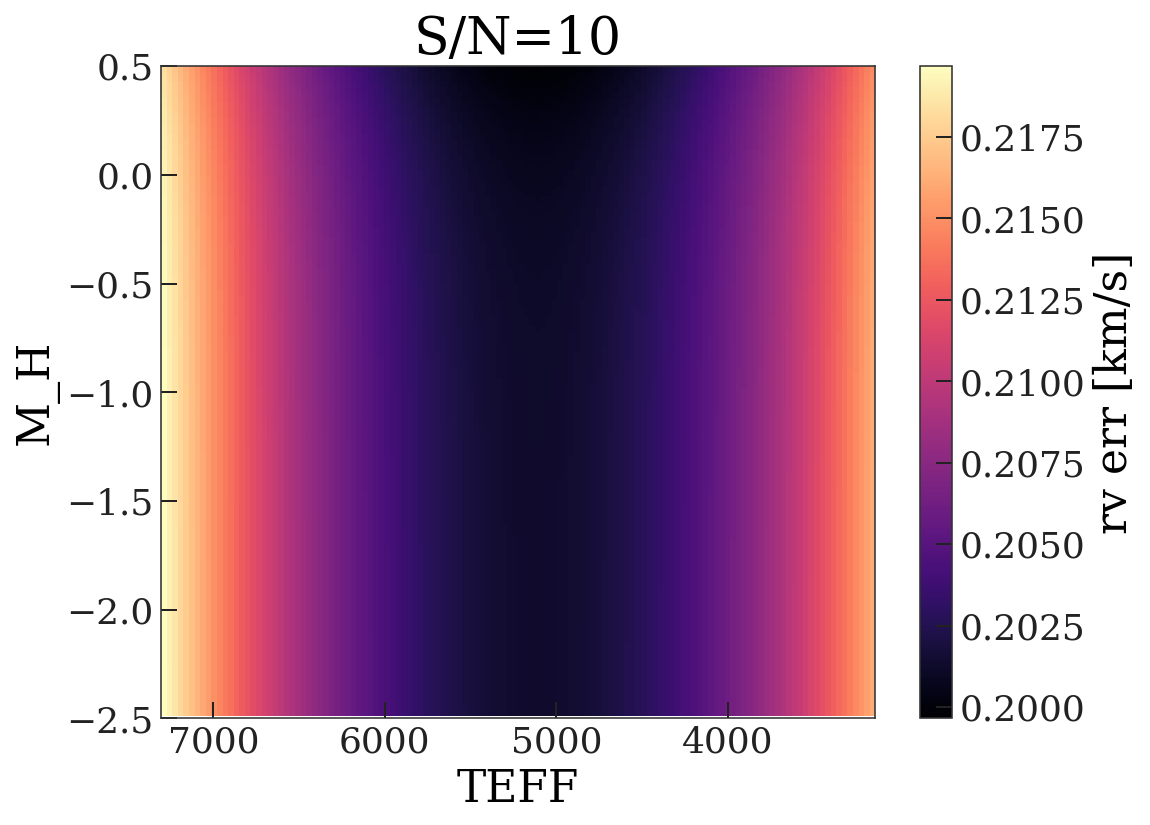

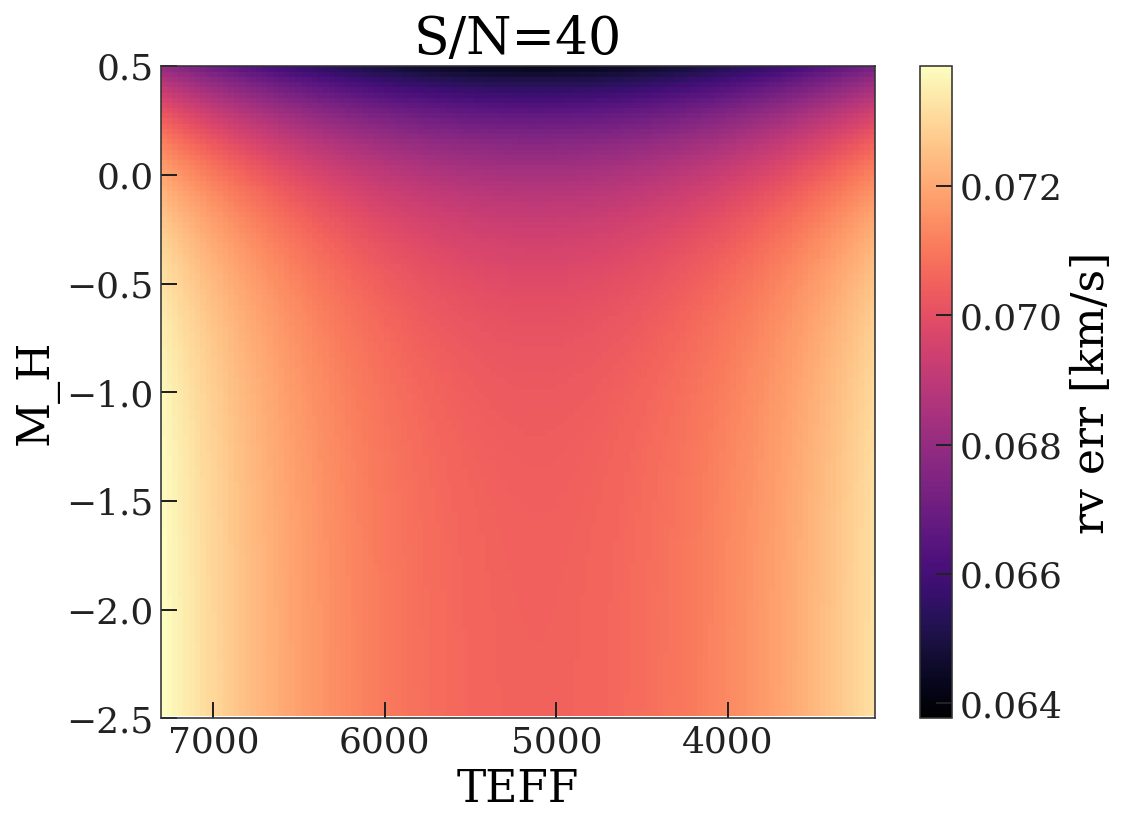

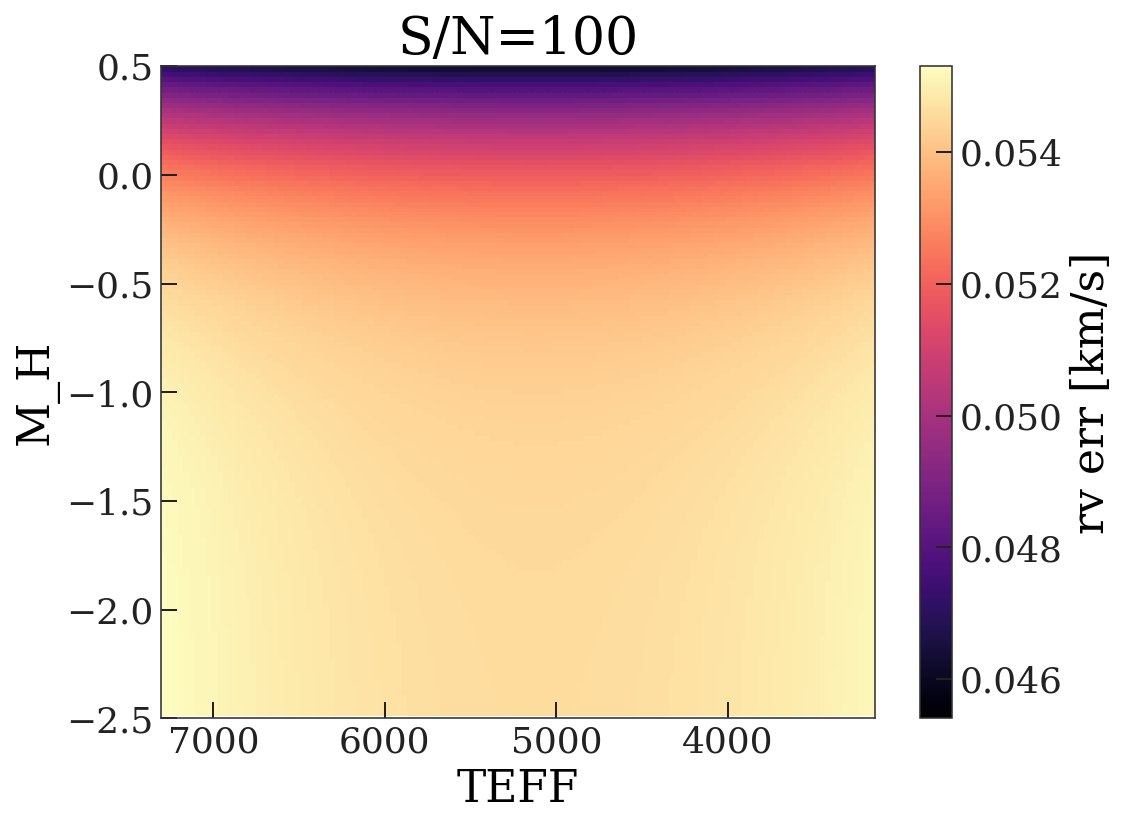

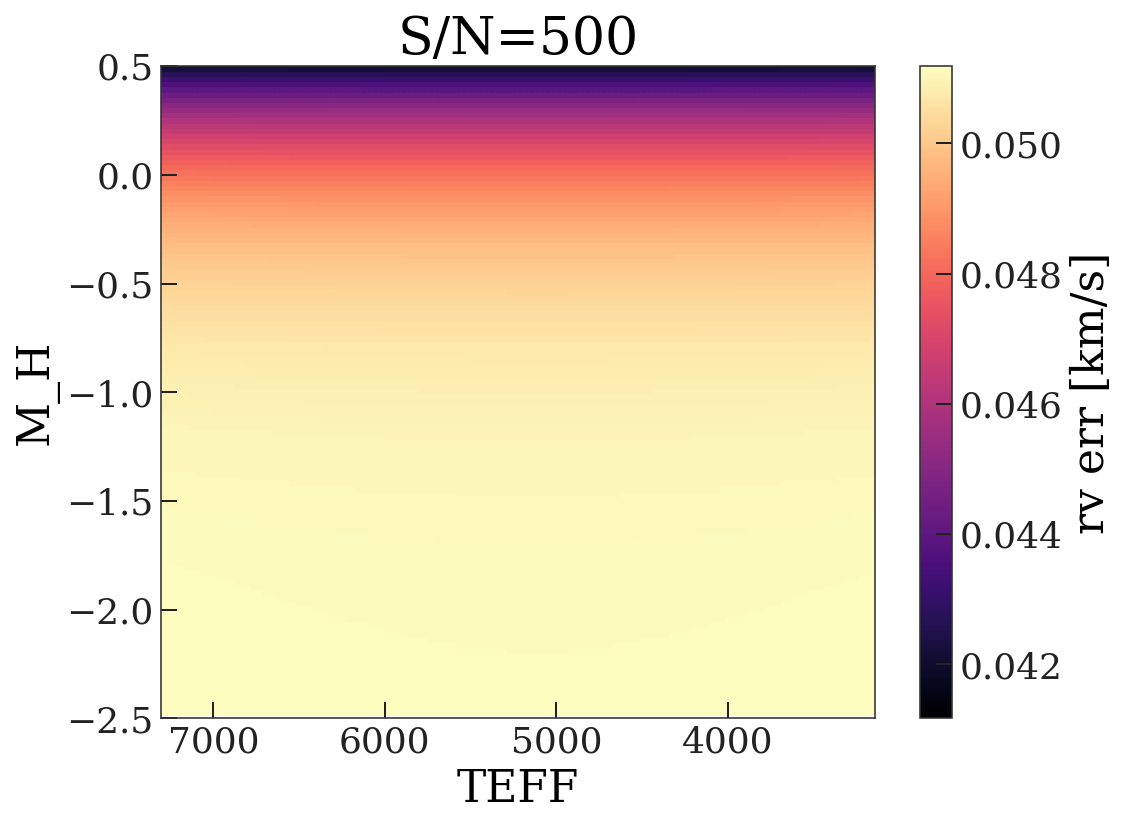

In [143]:
for snr in [10, 40, 100, 500]:
    fake_data = {'snrs': np.full(len(fake_teffs), snr), 
                 'teffs': fake_teffs,
                 'm_hs': fake_m_hs}

    with crazy_model2:
        # pm.set_data(data)
        pm.set_data(fake_data)
        test = xo.eval_in_model(err1, point=map_estimate)

    fig = plt.figure(figsize=(8, 6))
    plt.pcolormesh(teff_grid, m_h_grid, 
                   test.reshape(len(m_h_grid), len(teff_grid)))
    cb = plt.colorbar()
    cb.set_label('rv err [km/s]')

    plt.xlabel('TEFF')
    plt.ylabel('M_H')
    plt.xlim(teff_grid.max(), teff_grid.min())
    plt.ylim(-2.5, 0.5)
    plt.title(f"S/N={fake_data['snrs'][0]:.0f}")
    fig.set_facecolor('w')